In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import gym
from gym import spaces
import random
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings("ignore")
# from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

# Import Data

In [2]:
folder_path = '../csv/solar_energy_prod'
all_csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

df_list = [pd.read_csv(file) for file in all_csv_files]
df = pd.concat(df_list, ignore_index=True)

df['datetime']=pd.to_datetime(df['date']).drop(columns=['date'])
df['date'] = pd.to_datetime(df['datetime'].dt.date)

print(df.shape)
df.head()

(258423, 9)


,name,id,address,date,kWh,public_url,installationDate,uid,datetime
0,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11,1.130,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 08:00:00,2017-09-11 08:00:00
1,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11,2.340,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 09:00:00,2017-09-11 09:00:00
2,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11,3.656,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 10:00:00,2017-09-11 10:00:00
3,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11,4.577,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 11:00:00,2017-09-11 11:00:00
4,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11,6.506,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 12:00:00,2017-09-11 12:00:00


# Data Preparation

In [3]:
print(df.dtypes)
df['kWh'].describe()

name                        object
id                           int64
address                     object
date                datetime64[ns]
kWh                        float64
public_url                  object
installationDate            object
uid                         object
datetime            datetime64[ns]
dtype: object


count    258423.000000
mean         38.059762
std          71.598031
min           0.000000
25%           1.370000
50%           8.034000
75%          35.876000
max         514.462000
Name: kWh, dtype: float64

In [4]:
# df['datetime']=pd.to_datetime(df['date'])
df.sort_values(by=['name','datetime'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
plant = 'Whitehorn Multi-Service Centre'
df0 = df[df.name==plant]
df0.count()['date']

np.int64(27716)

In [6]:
# plt.style.use('fivethirtyeight')
# plt.plot(df0.date, df0['kWh'], label=f'{plant} Solar Energy Production')
# plt.tight_layout()
# plt.xlabel("DateTime")
# plt.ylabel("kWh Solar Produced")
# plt.xticks(rotation=30)
# plt.legend()
# plt.grid(True)

# plt.show()

In [7]:
min_max_dates = df['date'].agg(['min', 'max'])

print("Min and Max Dates:")
print(min_max_dates)

Min and Max Dates:
min   2015-09-01
max   2023-03-16
Name: date, dtype: datetime64[ns]


In [8]:
# filter for two years
df1 = df0[df0.date>='2021/01/01']
min_max_dates = df1['date'].agg(['min', 'max'])

print("Min and Max Dates after date filtering:")
print(min_max_dates)

Min and Max Dates after date filtering:
min   2021-01-01
max   2023-03-16
Name: date, dtype: datetime64[ns]


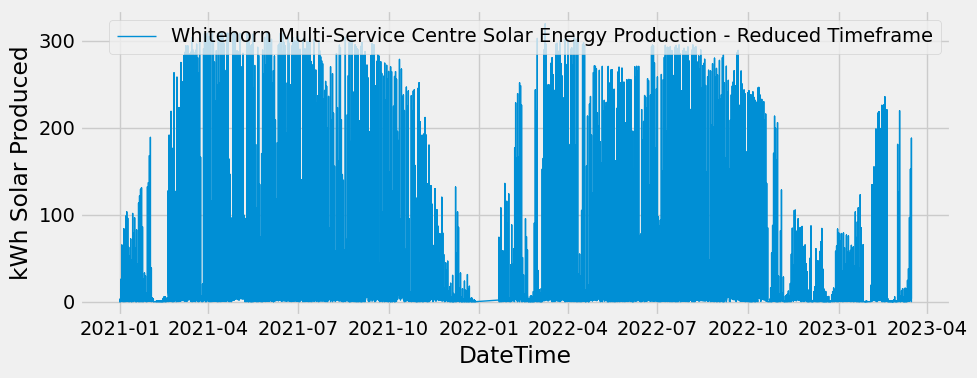

In [9]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 4))

plt.plot(df1.date, df1['kWh'], label=f'{plant} Solar Energy Production - Reduced Timeframe', linewidth=1)
plt.xlabel("DateTime")
plt.ylabel("kWh Solar Produced")

plt.tight_layout()
plt.legend()
plt.grid(True)

plt.show()

#### Aggregate by date to eliminate noiseness of hourly data (nights do not have solar output)

In [10]:
df_agg = df1.groupby(['name','date']).agg({'kWh':'sum'}).reset_index()
df_agg.head()

,name,date,kWh
0,Whitehorn Multi-Service Centre,2021-01-01,7.017
1,Whitehorn Multi-Service Centre,2021-01-02,73.606
2,Whitehorn Multi-Service Centre,2021-01-03,293.457
3,Whitehorn Multi-Service Centre,2021-01-04,159.021
4,Whitehorn Multi-Service Centre,2021-01-05,375.844


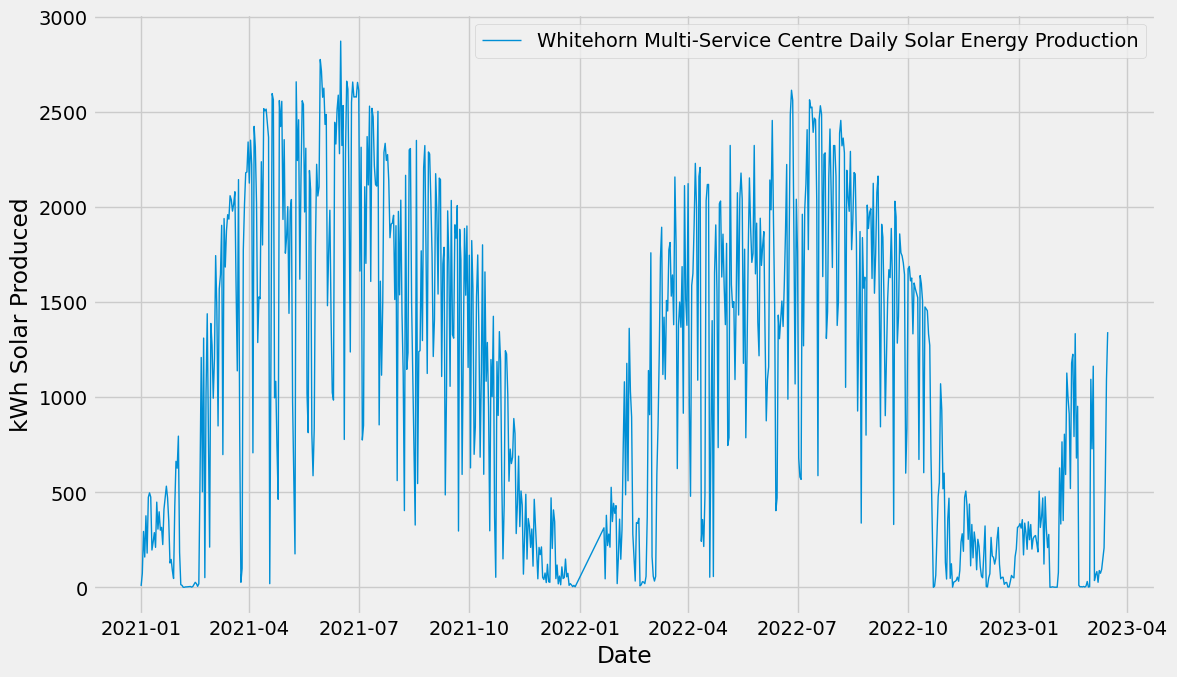

In [11]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 7))

plt.plot(df_agg.date, df_agg['kWh'], label=f'{plant} Daily Solar Energy Production', linewidth=1)
plt.xlabel("Date")
plt.ylabel("kWh Solar Produced")

plt.tight_layout()
plt.legend()
plt.grid(True)

plt.show()

### Seasonality

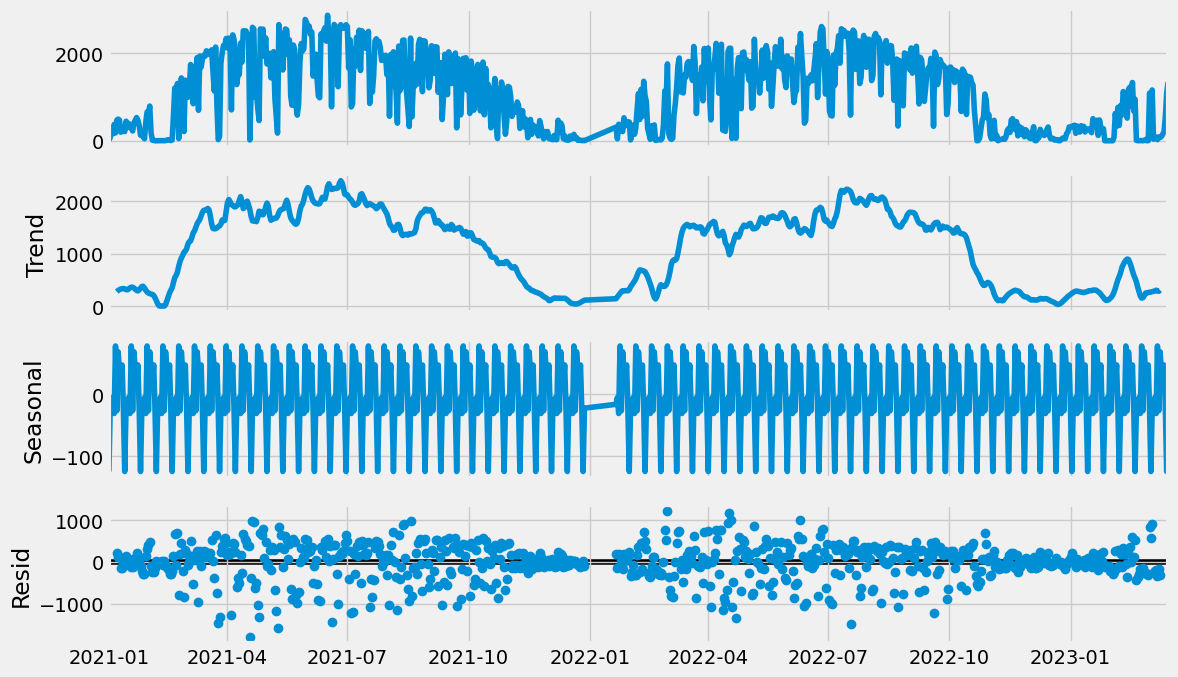

In [12]:
df_ts = df_agg[['date','kWh']].set_index('date')

# Decompose the time series (assuming monthly seasonality, period=12)
decomposition = seasonal_decompose(df_ts, model='additive', period=12)

# Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches((12, 7))
fig.tight_layout()
plt.show()

# Q-Learning Anomaly Detection Environment

In [13]:
class AnomalyDetectionEnv:
    def __init__(self, data):
        self.data = data
        self.current_step = 0
        self.action_space = spaces.Discrete(2)  # 0: no anomaly, 1: anomaly
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32)
        self.flagged_anomalies = []  # Store flagged anomalies

    def step(self, action):
        # Get the current data point and index
        current_value = self.data[self.current_step]
        current_index = self.current_step
        
        # If the agent flags it as an anomaly, store it
        if action == 1:  # 1 means anomaly
            self.flagged_anomalies.append((current_index, current_value))
        
        # Move to the next step
        self.current_step += 1
        done = self.current_step >= len(self.data)
        
        # Return observation, reward, done, and info
        return np.array([current_value]), 0, done, {}

    def reset(self):
        self.current_step = 0
        self.flagged_anomalies = []  # Reset anomalies for a new episode
        return np.array([self.data[self.current_step]])

In [14]:
class QLearningAgent:
    def __init__(self, action_size):
        self.action_size = action_size
        self.q_table = {}
        self.alpha = 0.1  # Learning rate
        self.gamma = 0.9  # Discount factor
        self.epsilon = 0.85  # Exploration rate (1.0)
        self.epsilon_decay = 0.75 # 0.99
        self.epsilon_min = 0.05 # 0.1

    def get_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, self.action_size - 1)
        return np.argmax(self.q_table.get(tuple(state.flatten()), [0]*self.action_size))

    def update_q_value(self, state, action, reward, next_state):
        state_key = tuple(state.flatten())
        next_state_key = tuple(next_state.flatten())
        current_q = self.q_table.get(state_key, [0]*self.action_size)[action]
        max_future_q = max(self.q_table.get(next_state_key, [0]*self.action_size))
        
        new_q = (1 - self.alpha) * current_q + self.alpha * (reward + self.gamma * max_future_q)
        if state_key not in self.q_table:
            self.q_table[state_key] = [0] * self.action_size
        self.q_table[state_key][action] = new_q

In [15]:
# Training the agent
env = AnomalyDetectionEnv(df_agg['kWh'].values)
agent = QLearningAgent(env.action_space.n)
num_episodes = 100

for episode in range(num_episodes):
    state = env.reset()
    done = False
    while not done:
        # Agent selects an action
        action = agent.get_action(state)
        # Environment responds to the action
        next_state, reward, done, _ = env.step(action)
        agent.update_q_value(state, action, reward, next_state)
        state = next_state
    agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)

In [16]:
# Print flagged anomalies
# print("Flagged anomalies:", env.flagged_anomalies)

In [17]:
# Extract anomaly indexes
anomaly_indexes = {index for index, value in env.flagged_anomalies}

# Add a new column to the DataFrame
df_agg['qlearn_anomaly'] = df_agg.index.isin(anomaly_indexes).astype(int)

In [18]:
df_agg['qlearn_anomaly'].sum()

np.int64(16)

In [61]:
len(df_agg)

782

In [19]:
print(f"Q-Learning has detected anomalies in {100*df_agg['qlearn_anomaly'].sum()/len(df_agg):.2f}% of the observations")

Q-Learning has detected anomalies in 2.05% of the observations


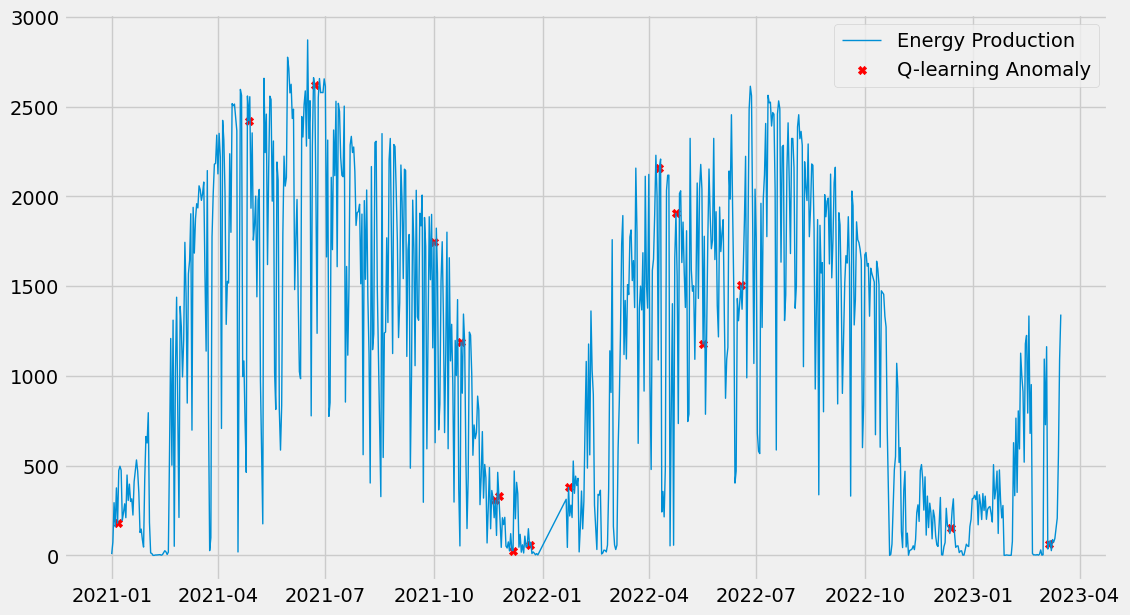

In [39]:
ql_anomaly_indices = np.where(df_agg.qlearn_anomaly==1)[0]
q_anomaly_x = df_agg['date'][ql_anomaly_indices]
q_anomaly_y = df_agg['kWh'][ql_anomaly_indices]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 7))
# Plot the line chart
plt.plot(df_agg['date'], df_agg['kWh'], label='Energy Production', linewidth=1)

# Mark anomalies with a different marker
plt.scatter(q_anomaly_x, q_anomaly_y, color='red', marker='X', s=35, label='Q-learning Anomaly')
plt.legend()
plt.show()

In [21]:
# Evaluate the agent
# state = env.reset()
# done = False
# total_reward = 0

# while not done:
#     action = agent.get_action(state)
#     next_state, reward, done, _ = env.step(action)
#     total_reward += reward
#     state = next_state

# print(f'Total reward during evaluation: {total_reward}')

# Let's compare the Q-Learning anomalies with the results from an Isolation Forest

### Features for Model

In [22]:
df2 = df_agg.sort_values("date")

window = 7 # to capture the previous week

# Calculate rolling mean, minimum 1 period to avoid NaN
df2["rolling_mean"] = df2["kWh"].rolling(window=window, min_periods=1).mean()

# Calculate rolling standard deviation, minimum 1 period
df2["rolling_std"] = df2["kWh"].rolling(window=window, min_periods=1).std()

# Calculate rolling maximum, minimum 1 period
df2["rolling_max"] = df2["kWh"].rolling(window=window, min_periods=1).max()

# Calculate rolling minimum, minimum 1 period
df2["rolling_min"] = df2["kWh"].rolling(window=window, min_periods=1).min()

# Create lag features: value shifted by 1
df2["lag_1"] = df2["kWh"].shift(1)

# Create lag features: value shifted by 6
df2["lag_3"] = df2["kWh"].shift(6)

# Calculate the percentage change from the previous value
df2["pct_change"] = df2["kWh"].pct_change()

In [23]:
feature_cols = [
    "kWh",
    "rolling_mean",
    "rolling_std",
    "rolling_max",
    "rolling_min",
    "lag_1",
    "lag_3",
    "pct_change",
]

df2[feature_cols] = df2[feature_cols].replace([np.inf, -np.inf], np.nan)
df2[feature_cols] = df2[feature_cols].fillna(method="ffill").fillna(method="bfill")

In [24]:
# Initialize RobustScaler to scale features while being robust to outliers
scaler = RobustScaler()

# Fit the scaler on the feature matrix and transform the features accordingly
X = scaler.fit_transform(df2[feature_cols])

In [25]:
#TODO: update definition to return granular outlier status per observation to be used on validation set
def estimate_contamination(X, std_dev_threshold):
    """
    Estimate the contamination rate based on the proportion of outliers in each feature.
    
    Parameters:
    - X: numpy array of feature values
    
    Returns:
    - average_contamination: float representing the average contamination rate across features
    """
    outlier_proportions = []
    
    for feature_idx in range(X.shape[1]):
        # Extract all values for the current feature
        feature_values = X[:, feature_idx]
        
        # Calculate mean and standard deviation of the feature
        mean = np.mean(feature_values)
        std = np.std(feature_values)
        
        # Count the number of outliers beyond 3 standard deviations from the mean
        outliers = np.sum(np.abs(feature_values - mean) > std_dev_threshold * std)

        # Calculate the proportion of outliers in the current feature
        outlier_proportions.append(outliers / len(feature_values))
    
    # Return the average contamination rate across all features
    return np.mean(outlier_proportions), std_dev_threshold

In [26]:
def calc_outliers(df, feature, std_dev_threshold):

    X_feat = scaler.fit_transform(df[[feature]])
    df_feat = pd.DataFrame(X_feat, columns=[f'{feature}_scaled']).join(df[[feature, 'kWh']])
    
    df_feat['avg'] = df_feat[f'{feature}_scaled'].mean()
    df_feat['std'] = df_feat[f'{feature}_scaled'].std()
    df_feat[f'{feature}_outlier'] = np.where( abs(df_feat[f'{feature}_scaled'] - df_feat['avg']) > std_dev_threshold*df_feat['std'], 1, 0)
        
    return df_feat

In [27]:
# Estimate the contamination rate
contamination, std_dev_threshold = estimate_contamination(X=X, std_dev_threshold=1.75)

print(f"Based on a Std Dev Threshold of {std_dev_threshold}, the Estimated Contamination Rate is {100*contamination:.2f}% of the observations")

Based on a Std Dev Threshold of 1.75, the Estimated Contamination Rate is 2.59% of the observations


### Isolation Forest Model Training and Prediction
* Input a higher contamination rate to match the results of the Q Learning

In [28]:
X_train, X_val = train_test_split(X, test_size=0.2, random_state=12)

clf = IsolationForest(contamination=0.0217, random_state=12)

# Fit the Isolation Forest model on the training data
clf.fit(X_train)

,n_estimators,100
,max_samples,'auto'
,contamination,0.0217
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,12
,verbose,0
,warm_start,False


In [29]:
X_val_rolling_mean = X_val[:, 1]
df_X_val_rolling_mean = pd.DataFrame(X_val_rolling_mean, columns=['rolling_mean']).join(df2[['kWh']])

df_outliers_X_val = calc_outliers(df=df_X_val_rolling_mean, feature='rolling_mean', std_dev_threshold=1.75)
val_true = df_outliers_X_val['rolling_mean_outlier'].to_numpy()

In [30]:
val_pred = clf.predict(X_val)
# convert from -1,1 to 0,1
val_pred = [0 if x == 1 else 1 for x in val_pred]

df_val_pred = pd.DataFrame(val_pred, columns=['isolation_forest_outlier'])
df_eval_outliers_comp = df_outliers_X_val.join(df_val_pred)

#### Comparison of Rolling Mean Std Dev Outliers and Isolation Forest Outliers found in the Evaluation Set
* Here, we are assuming the Rolling Mean model is Ground Truth!

In [31]:
df_eval_outliers_comp[(df_eval_outliers_comp.rolling_mean_outlier==1) | (df_eval_outliers_comp.isolation_forest_outlier==1)]

,rolling_mean_scaled,rolling_mean,kWh,avg,std,rolling_mean_outlier,isolation_forest_outlier
77,0.851269,0.870317,2015.277,-0.19258,0.559915,1,1
87,0.821703,0.841672,2179.380,-0.19258,0.559915,1,1
99,-1.030009,-0.952308,1517.073,-0.19258,0.559915,0,1
110,0.675409,0.699940,2562.476,-0.19258,0.559915,0,1
111,0.812313,0.832575,995.997,-0.19258,0.559915,1,1
118,-0.999364,-0.922618,1933.806,-0.19258,0.559915,0,1
138,0.011700,0.056923,1017.987,-0.19258,0.559915,0,1
155,0.805534,0.826007,1480.285,-0.19258,0.559915,1,1


In [32]:
f1 = f1_score(val_true, val_pred)
print(f"F1 Score when comparing 'Isolation Forest' Model to 'Rolling Mean Std Dev Threshold={std_dev_threshold}' Ground Truth Model: {f1:.4f}")

F1 Score when comparing 'Isolation Forest' Model to 'Rolling Mean Std Dev Threshold=1.75' Ground Truth Model: 0.6667


In [33]:
# Predict anomalies on the entire dataset using the trained Isolation Forest model
df2["isolation_forest_anomaly"] = clf.predict(X)

# Map the predictions to binary labels: 0 for normal instances, 1 for anomalies
df2["isolation_forest_anomaly"] = df2["isolation_forest_anomaly"].map({1: 0, -1: 1})  # Convert to 0 (normal) and 1 (anomaly)

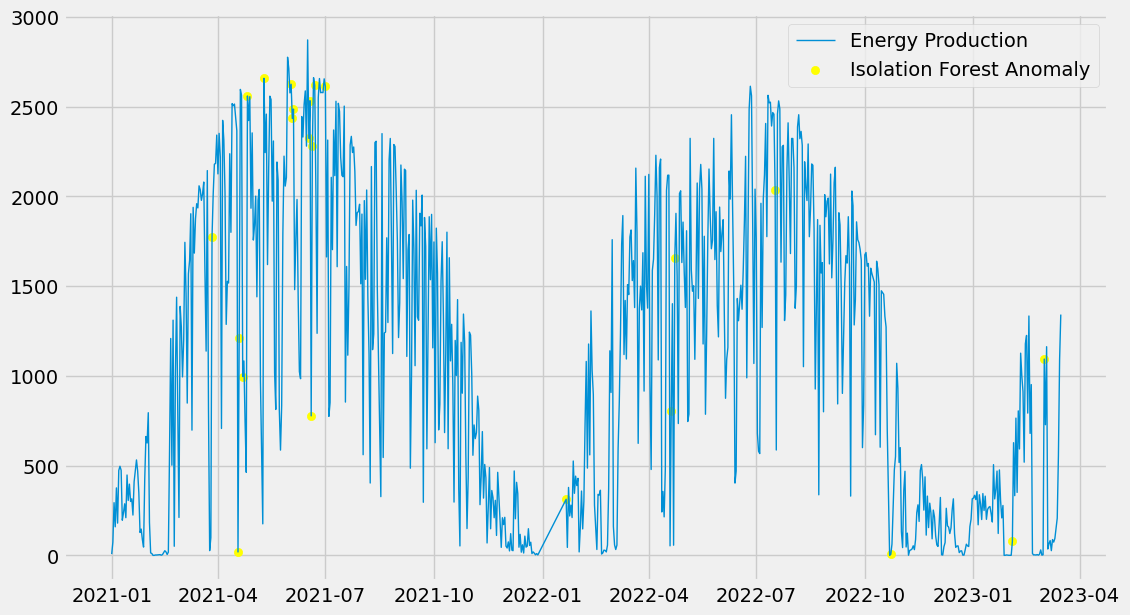

In [36]:
if_anomaly_indices = np.where(df2.isolation_forest_anomaly==1)[0]
if_anomaly_x = df2['date'][if_anomaly_indices]
if_anomaly_y = df2['kWh'][if_anomaly_indices]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 7))
# Plot the line chart
plt.plot(df2['date'], df2['kWh'], label='Energy Production', linewidth=1)

# Mark anomalies with a different marker
plt.scatter(if_anomaly_x, if_anomaly_y, color='yellow', marker='o', s=35, label='Isolation Forest Anomaly')
plt.legend()
plt.show()

### Calculate Rolling Mean model for entire observation set

In [38]:
df_complete_ground_truth = calc_outliers(df=df2, feature='rolling_mean', std_dev_threshold=1.75)
df3 = df2.join(df_complete_ground_truth[['rolling_mean_outlier']])

# Compare All Three Models

In [40]:
ql_anomaly_indices = np.where(df3.qlearn_anomaly==1)[0]
if_anomaly_indices = np.where(df3.isolation_forest_anomaly==1)[0]
rm_anomaly_indices = np.where(df3.rolling_mean_outlier==1)[0]

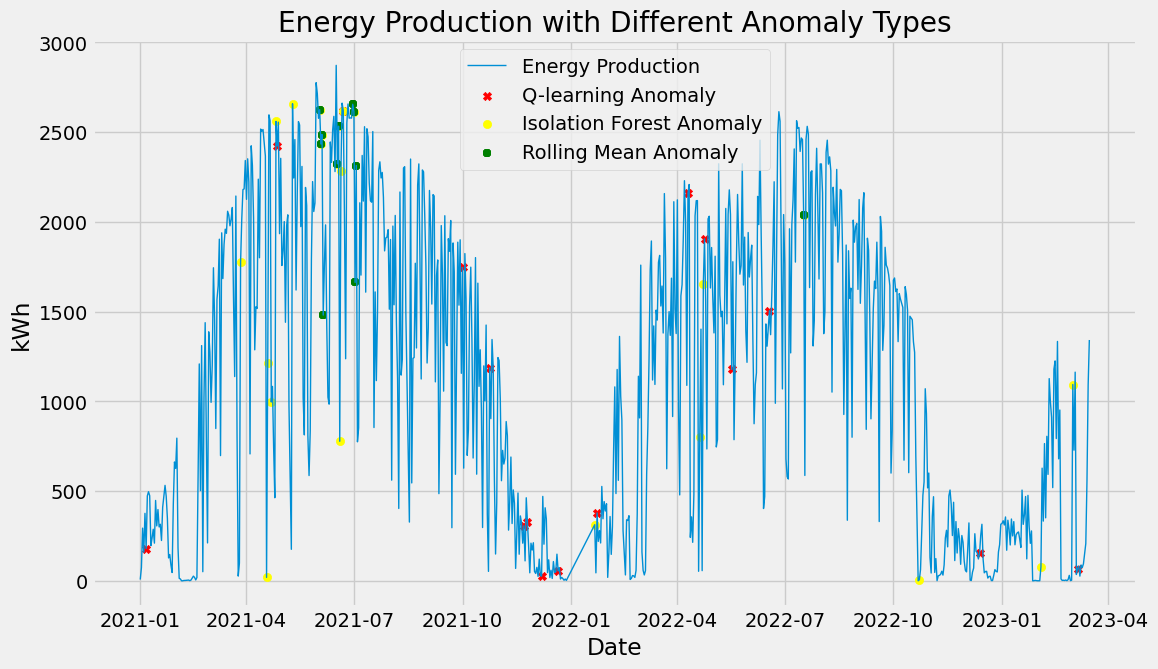

In [41]:
q_anomaly_x = df3['date'][ql_anomaly_indices]
q_anomaly_y = df3['kWh'][ql_anomaly_indices]
if_anomaly_x = df3['date'][if_anomaly_indices]
if_anomaly_y = df3['kWh'][if_anomaly_indices]
rm_anomaly_x = df3['date'][rm_anomaly_indices]
rm_anomaly_y = df3['kWh'][rm_anomaly_indices]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 7))
# Plot the line chart
plt.plot(df3['date'], df3['kWh'], label='Energy Production', linewidth=1)

# Mark anomalies with a different marker
plt.scatter(q_anomaly_x, q_anomaly_y, color='red', marker='X', s=35, label='Q-learning Anomaly')
plt.scatter(if_anomaly_x, if_anomaly_y, color='yellow', marker='o', s=35, label='Isolation Forest Anomaly')
plt.scatter(rm_anomaly_x, rm_anomaly_y, color='green', marker='+', s=35, label='Rolling Mean Anomaly')

plt.xlabel('Date')
plt.ylabel('kWh')
plt.title('Energy Production with Different Anomaly Types')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
df_summary = df3.groupby(['name','qlearn_anomaly','isolation_forest_anomaly','rolling_mean_outlier']).agg({'date':'count'}).rename(columns={'date':'count_obs'}).reset_index()
df_summary
df_tot = df_summary.groupby(['name']).agg({'count_obs':'sum'}).rename(columns={'count_obs':'tot_obs'}).reset_index()
df_summary2 = df_summary.merge(df_tot, how='left', on='name')
df_summary2['pct_tot'] = df_summary2.count_obs/df_summary2.tot_obs
df_summary2.drop(columns=['tot_obs'], inplace=True)
df_summary2

,name,qlearn_anomaly,isolation_forest_anomaly,rolling_mean_outlier,count_obs,pct_tot
0,Whitehorn Multi-Service Centre,0,0,0,741,0.947570
1,Whitehorn Multi-Service Centre,0,0,1,4,0.005115
2,Whitehorn Multi-Service Centre,0,1,0,14,0.017903
3,Whitehorn Multi-Service Centre,0,1,1,7,0.008951
4,Whitehorn Multi-Service Centre,1,0,0,15,0.019182
5,Whitehorn Multi-Service Centre,1,1,0,1,0.001279
